## 16.4 使用PyTorch实现DiscoGAN
人们在两个有内在关系的两个不同域之间，往往无须经过监督学习就能发现其对应关系，如一句中文与一句翻译后的英文之间的关系，选择与一条裙子具有相同风格的鞋子、提包等。对于机器来说，自动学习不同域的关系的挑战很大。不过探索生成式对抗网络（Discovery Generative Adversarial Network，DiscoGAN）在这方面取得了不俗的效果。
	探索生成式对抗网络涉及两个不同的视觉域的关系，将一个域的图像转化为另一个域，期间不需要任何两个域之间的关系信息。它的基本思想是确保所有在域1内的图像都可以用域2里的图像进行表示，利用重构损失来衡量原图像经过两次转换（即从域1到域2再到域1）后被重构的效果。DiscoGAN的工作原理如图16-15所示。
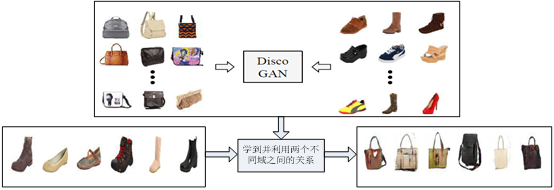
 <center>图16-15  DiscoGAN工作原理</center>
	利用DiscoGAN学到的提包与鞋子之间的内在关系，可以进行很多有意义的应用，如帮助电商向客户推荐配套衣服、鞋子、帽子等。

### 16.4.1 DiscoGAN架构
	DiscoGAN是一种能够自动学习并发现跨域关系的生成式对抗网络。该模型建立了从一个领域到另一个领域的映射关系。在训练过程中，使用两个不同的图像数据集，并且这两个数据集之间没有任何显式的标签，同时也不需要预训练。该模型由两个GAN模型组成，把一个领域中图像作为输入，然后输出另一个领域中对应的图像，其架构如图16-16所示
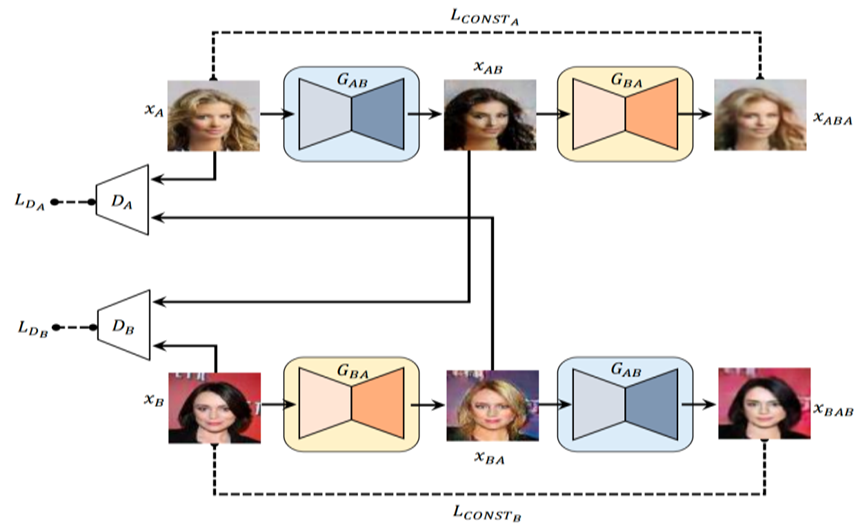
<center>图16-16 DiscoGAN的架构图</center>
这个架构看起来有点复杂，不过我们可以把它拆分一下。图16-17 是一个标准的GAN架构。

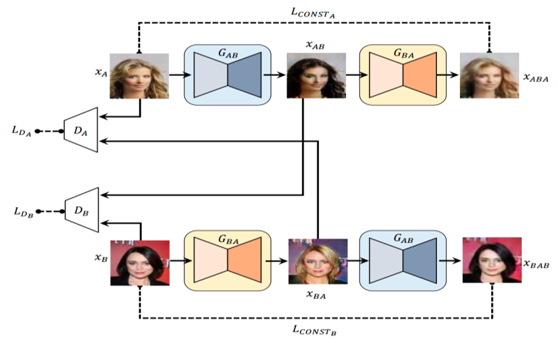
<center>图16-17 DiscoGAN中的GAN架构</center>
在图16-17中，生成器G_AB是一对编码器和解码器，D_B是判别器。在图16-17的架构中加上重构损失，便得到图16-18所示架构。

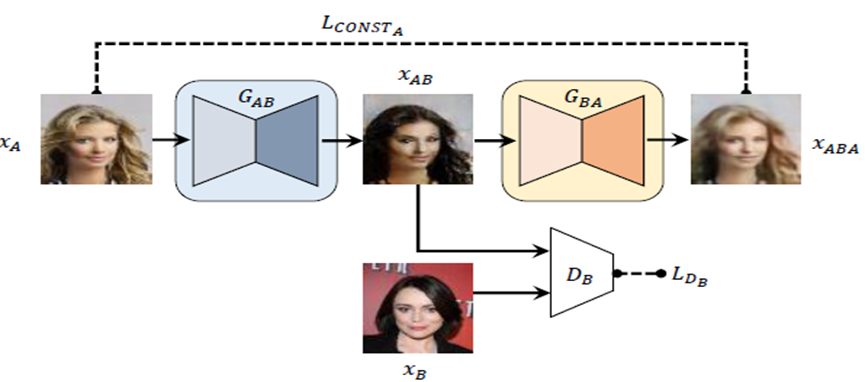
<center>图16-18  标准GAN加上重构损失的架构图</center>

- 图16-18中只有从A域到B域的映射关系，如果加上从B域到A域的映射关系，就得到图16-16。图中有很多字符，它们的具体含义如下。
- G_AB:是生成器函数，功能是将域A的图像x_A转换为域B的图像x_AB。
- G_BA:是生成器函数，功能是将域B的图像x_B转换为域A的图像x_BA。
- G_AB (x_A):包含了在域A的x_A经过转换后属于域B的所有可能结果。
- G_BA (x_B):包含了在域B的x_B经过转换后属于域A的所有可能结果。
- D_A:是域A内的判别器函数。
- D_B:是域B内的判别器函数。

### 16.4.2 损失函数
从图16-16可知，DiscoGAN能够学习两个领域之间的双射关系，它由两个带有重构损失的GAN组成，这两个模型同时训练，并且对应的产生器共享权值，产生的图像分别送往各自的判别器。产生器损失是两个GAN损失和两个重构损失项的和，判别器损失也是两个模型判别器损失的和

### 16.4.3 DiscoGAN实现
1）生成器的网络架构。

In [1]:
import torch
import torch.nn as nn

class GeneratorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, conv_dims, deconv_dims, num_gpu):
        super(GeneratorCNN, self).__init__()
        self.num_gpu = num_gpu
        self.layers = []

        prev_dim = conv_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 4, 2, 1, bias=False))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in conv_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        for out_dim in deconv_dims:
            self.layers.append(nn.ConvTranspose2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.ReLU(True))
            prev_dim = out_dim

        self.layers.append(nn.ConvTranspose2d(prev_dim, output_channel, 4, 2, 1, bias=False))
        self.layers.append(nn.Tanh())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

    def forward(self, x):
        return self.main(x)

2）判别器的网络结构。

In [2]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, hidden_dims, num_gpu):
        super(DiscriminatorCNN, self).__init__()
        self.num_gpu = num_gpu
        self.layers = []

        prev_dim = hidden_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 4, 2, 1, bias=False))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in hidden_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        self.layers.append(nn.Conv2d(prev_dim, output_channel, 4, 1, 0, bias=False))
        self.layers.append(nn.Sigmoid())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out.view(out.size(0), -1)

    def forward(self, x):
        return self.main(x)


### 16.4.4 使用PyTorch实现从边框生成鞋子

In [4]:
#以便自动导入在DiscoGAN12目录下的文件或子目录下的文件
import sys
sys.path.append("./DiscoGAN12/")

import torch

from DiscoGAN12.trainer import Trainer
from DiscoGAN12.config import get_config
from DiscoGAN12.data_loader import get_loader
from DiscoGAN12.utils import prepare_dirs_and_logger, save_config

In [5]:
def main(config):
    prepare_dirs_and_logger(config)

    torch.manual_seed(config.random_seed)
    if config.num_gpu > 0:
        torch.cuda.manual_seed(config.random_seed)

    if config.is_train:
        data_path = config.data_path
        batch_size = config.batch_size
    else:
        if config.test_data_path is None:
            data_path = config.data_path
        else:
            data_path = config.test_data_path
        batch_size = config.sample_per_image

    a_data_loader, b_data_loader = get_loader(
            data_path, batch_size, config.input_scale_size,
            config.num_worker, config.skip_pix2pix_processing)

    trainer = Trainer(config, a_data_loader, b_data_loader)

    if config.is_train:
        save_config(config)
        trainer.train()
    else:
        if not config.load_path:
            raise Exception("[!] You should specify `load_path` to load a pretrained model")
        trainer.test()


In [8]:
if __name__ == "__main__":
    config, unparsed = get_config()
    print(config)
    #main(config)

Namespace(a_grayscale=False, b_grayscale=False, batch_size=200, beta1=0.5, beta2=0.999, cnn_type=0, d_num_layer=5, data_dir='DiscoGAN12/data', dataset='edges2shoes', fc_hidden_dim=128, g_num_layer=3, input_scale_size=64, is_train=False, load_path='logs/edges2shoes_2019-05-24_10-37-37', log_dir='logs', log_level='INFO', log_step=50, loss='log_prob', lr=0.0002, max_step=9000, num_gpu=0, num_log_samples=3, num_worker=12, optimizer='adam', random_seed=123, sample_per_image=64, save_step=500, skip_pix2pix_processing=False, test_data_path=None, weight_decay=0.0001)


In [7]:
#https://github.com/carpedm20/DiscoGAN-pytorch

In [5]:
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

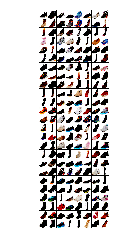

In [11]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/8950_x_BAB.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()


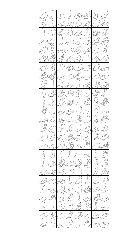

In [12]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/valid_x_A.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

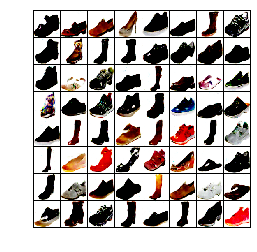

In [7]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_AB.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

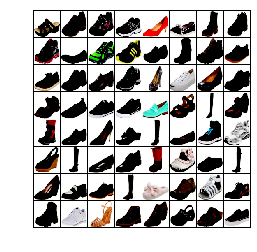

In [14]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_B.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

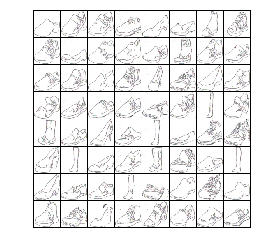

In [15]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_BA.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

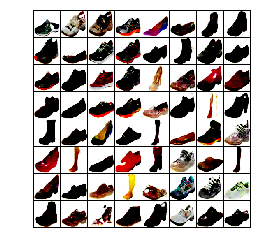

In [16]:
reconsPath = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_BAB.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

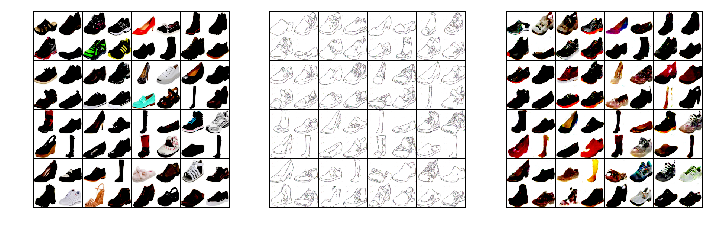

In [28]:
plt.figure(figsize=(12,8))
reconsPath1 = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_B.png'
Image1 = mpimg.imread(reconsPath1)
reconsPath2 = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_BA.png'
Image2 = mpimg.imread(reconsPath2)
reconsPath3 = 'logs/edges2shoes_2019-05-24_10-37-37/test/25_x_BAB.png'
Image3 = mpimg.imread(reconsPath3)
plt.subplot(1,3,1)
plt.imshow(Image1) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,3,2)
plt.imshow(Image2) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.subplot(1,3,3)
plt.imshow(Image3) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()